# W207 Final Project
## Home Price Prediction
Mona Iwamoto, Michelle Kim, Alex Nocella

### Introduction
This project is based on the Kaggle competition *HOME PRICE PREDICTION*
https://www.kaggle.com/c/house-prices-advanced-regression-techniques. It utilizes the Ames, Iowa data set which contains 79 features. Our goal is to predict the sales prices in the test dataset.  Submissions
to the competition are evaluated base on the Root-Mean-Squared-Error (RMSE) between the *logarithm* of the predicted value and the *logarithm* of the observed sales price.

### Import data and tools
For this project we are using tools from scikit-learn to model our data.

In [1]:
#  Import Tools
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import seaborn as sns

from sklearn import ensemble, tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from tabulate import tabulate
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA

/Users/mona/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Import raw data
train_raw = pd.read_csv('train.csv')
print 'Raw data": ', train_raw.shape
test = pd.read_csv('test.csv')
print 'Test data: ', test.shape
train_raw.head()

Raw data":  (1460, 81)
Test data:  (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Data Preparation
To prepare the data for modeling, we examine the data for missing values, remove some features with too little data and fill in other missing data with the most popular values. We combine the data from both the test and training set for the purpose of characterizing the data and minimizing the manipulation of datasets.

In [3]:
# Missing Data
NAs = pd.concat([train_raw.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0]


,Train,Test
Alley,1369,1352.0
BsmtCond,37,45.0
BsmtExposure,38,44.0
BsmtFinSF1,0,1.0
BsmtFinSF2,0,1.0
BsmtFinType1,37,42.0
BsmtFinType2,38,42.0
BsmtFullBath,0,2.0
BsmtHalfBath,0,2.0
BsmtQual,37,44.0


In [4]:
# Data cleaning for both training and test sets

train_price = train_raw.SalePrice

# Remove features with 50% or greater Missing Data
features = pd.concat([train_raw, test], keys=['train', 'test'])
features.drop(['Utilities', 'RoofMatl', 'MasVnrArea', 'BsmtFinSF1', 
               'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'LowQualFinSF',
               'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'GarageYrBlt',
               'GarageArea', 'GarageCond', 'WoodDeckSF',
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
               'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal'],
              axis=1, inplace=True)

# Fill in other missing data
# MSZoning NA in pred. filling with most popular values
features['MSZoning'] = features['MSZoning'].fillna(features['MSZoning'].mode()[0])
features['MasVnrType'] = features['MasVnrType'].fillna(features['MasVnrType'].mode()[0])
features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])
features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].mean())

features['Alley'] = features['Alley'].fillna('NOACCESS')
features['FireplaceQu'] = features['FireplaceQu'].fillna('NoFP')

# NA's for basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('NoBSMT')
features['TotalBsmtSF'] = features['TotalBsmtSF'].fillna(0)

# NA's for Garage
for col in ('GarageType', 'GarageFinish', 'GarageQual'):
    features[col] = features[col].fillna('NoGRG')
features['GarageCars'] = features['GarageCars'].fillna(0.0)

# Convert features to appropriate types
for col in ('MSSubClass','OverallCond','KitchenAbvGr','YrSold','MoSold'):
    features[col] = features[col].astype(str)

# Convert to total square footage
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)

# Add GrLivAreaSq
features['GrLivAreaSq'] = features['GrLivArea']**2


In [5]:
print features.shape
print features.columns.values

(2919, 56)
['Alley' 'BedroomAbvGr' 'BldgType' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1'
 'BsmtFinType2' 'BsmtQual' 'CentralAir' 'Condition1' 'Condition2'
 'Electrical' 'ExterCond' 'ExterQual' 'Exterior1st' 'Exterior2nd'
 'FireplaceQu' 'Fireplaces' 'Foundation' 'FullBath' 'GarageCars'
 'GarageFinish' 'GarageQual' 'GarageType' 'GrLivArea' 'HalfBath'
 'HeatingQC' 'HouseStyle' 'Id' 'KitchenAbvGr' 'KitchenQual' 'LandContour'
 'LandSlope' 'LotArea' 'LotConfig' 'LotFrontage' 'LotShape' 'MSSubClass'
 'MSZoning' 'MasVnrType' 'MoSold' 'Neighborhood' 'OverallCond'
 'OverallQual' 'PavedDrive' 'RoofStyle' 'SaleCondition' 'SalePrice'
 'SaleType' 'Street' 'TotRmsAbvGrd' 'YearBuilt' 'YearRemodAdd' 'YrSold'
 'TotalSF' 'GrLivAreaSq']


After some features are combined or eliminated, we have 56 features remaining.
Next we transform some numeric features.  Because of a large right skew in the sales prices, we use the log values.  Additionally, we take logs and standardize 'LotFrontage', 'LotArea', 'TotalSF','GrLivArea' and 'GrLivAreaSq'

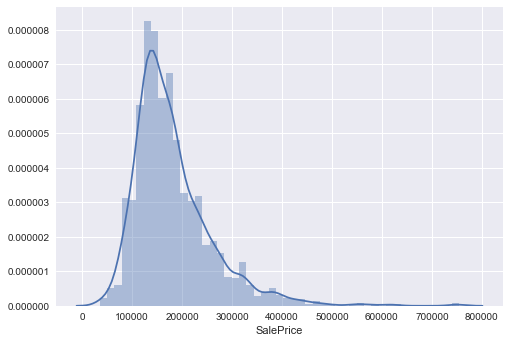

In [6]:
# Transformations 
sns.distplot(train_price)

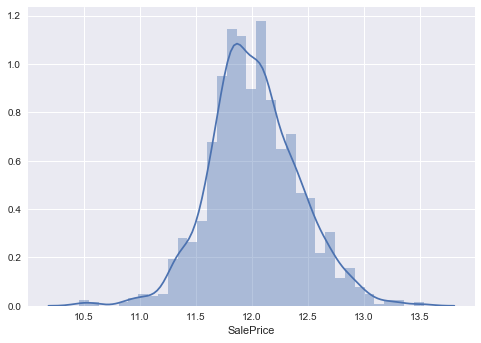

In [7]:
# Large right skew so let's take a log of the SalePrice
train_price = np.log(train_price)
sns.distplot(train_price)

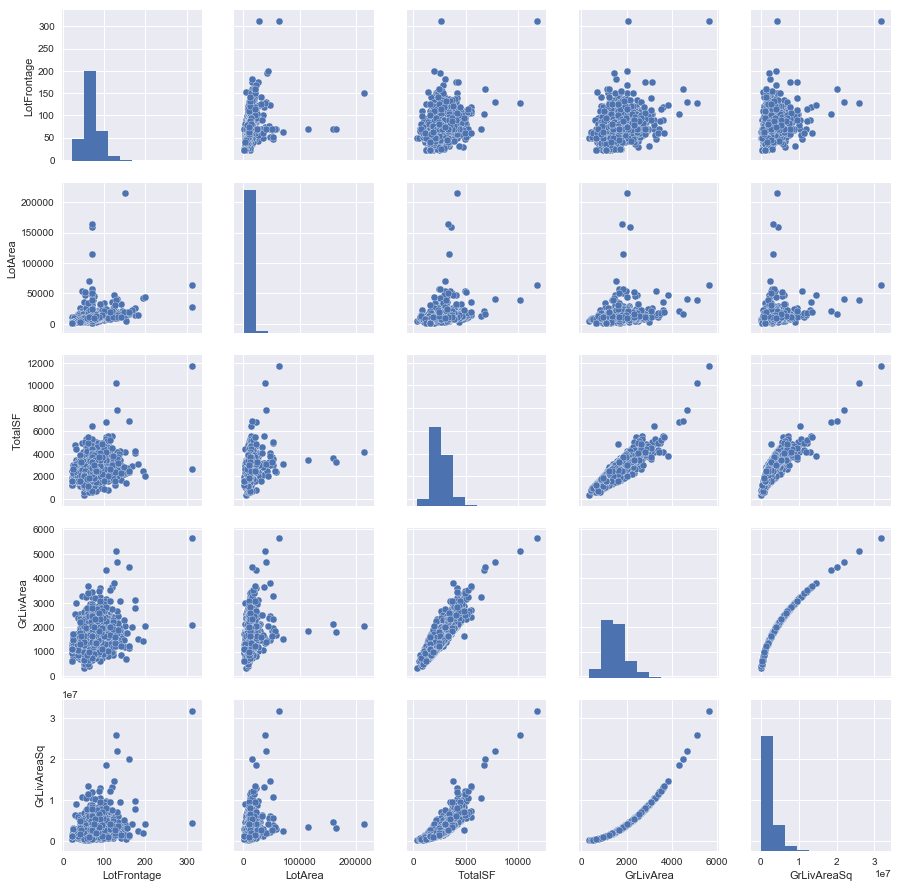

In [8]:
features_to_standardize = [col for col in ['LotFrontage', 'LotArea', 'TotalSF',
                          'GrLivArea', 'GrLivAreaSq'] if col in features.columns]
# Get a flavor of what a few of these variables look like -- they're basically all square footage
sns.pairplot(features[features_to_standardize[0:min(5, len(features_to_standardize))]])

(2919, 56)

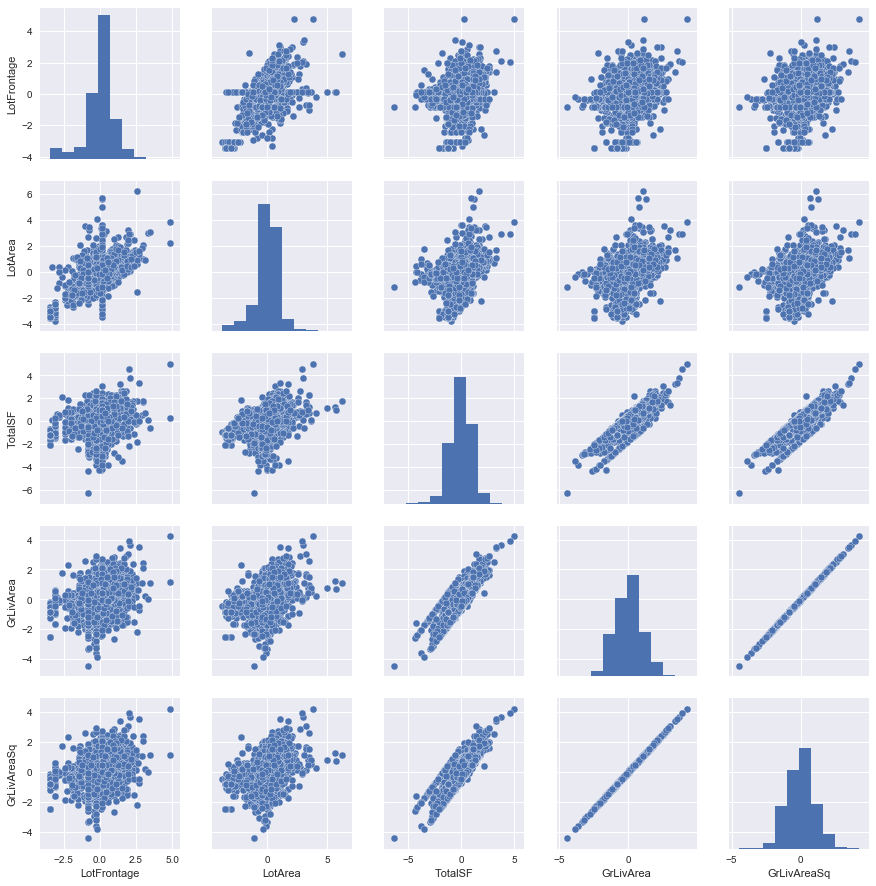

In [9]:
# Take logs, then standardize
def log_and_standardize(df, cols):
    df[cols] = np.log(df[cols] + 1)
    df[cols] = ((df[cols] - df[cols].mean())) / df[cols].std()
    return df
    
features = log_and_standardize(features, features_to_standardize)

# Plot them again
sns.pairplot(features[features_to_standardize[0:min(5, len(features_to_standardize))]])
features.shape


For catagorical features we create dummy variables.

In [10]:
# Create dummy variables for categorical features

# Create dummy from Condition1 and Condition2 
# Condition1: Proximity to various conditions
# Condition2: Proximity to various conditions (if more than one is present)

conditions = set([x for x in features['Condition1']] + [x for x in features['Condition2']])
dummies = pd.DataFrame(data=np.zeros((len(features.index), len(conditions))),
                       index=features.index, columns=conditions)
for i, cond in enumerate(zip(features['Condition1'], features['Condition2'])):
    dummies.loc[i, cond] = 1
features = pd.concat([features, dummies.add_prefix('Condition_')], axis=1)
features.drop(['Condition1', 'Condition2'], axis=1, inplace=True)

# Create dummy from Exterior1st and Exterior2nd
# Exterior1st: Exterior covering on house
# Exterior2nd: Exterior covering on house (if more than one material)

exteriors = set([x for x in features['Exterior1st']] + [x for x in features['Exterior2nd']])
dummies = pd.DataFrame(data=np.zeros((len(features.index), len(exteriors))),
                       index=features.index, columns=exteriors)
for i, ext in enumerate(zip(features['Exterior1st'], features['Exterior2nd'])):
    dummies.loc[i, ext] = 1
features = pd.concat([features, dummies.add_prefix('Exterior_')], axis=1)
features.drop(['Exterior1st', 'Exterior2nd', 'Exterior_nan'], axis=1, inplace=True)

# Create other Dummies from all other categorical vars
for col in features.dtypes[features.dtypes == 'object'].index:
    for_dummy = features.pop(col)
    features = pd.concat([features, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [11]:
print features.columns.values
print features.shape

['BedroomAbvGr' 'Fireplaces' 'FullBath' 'GarageCars' 'GrLivArea' 'HalfBath'
 'Id' 'LotArea' 'LotFrontage' 'OverallQual' 'SalePrice' 'TotRmsAbvGrd'
 'YearBuilt' 'YearRemodAdd' 'TotalSF' 'GrLivAreaSq' 'Condition_PosN'
 'Condition_RRAe' 'Condition_RRNe' 'Condition_RRNn' 'Condition_RRAn'
 'Condition_PosA' 'Condition_Artery' 'Condition_Feedr' 'Condition_Norm'
 'Exterior_Brk Cmn' 'Exterior_Stone' 'Exterior_HdBoard' 'Exterior_BrkComm'
 'Exterior_CmentBd' 'Exterior_WdShing' 'Exterior_VinylSd' 'Exterior_Other'
 'Exterior_ImStucc' 'Exterior_Stucco' 'Exterior_Wd Sdng' 'Exterior_AsbShng'
 'Exterior_AsphShn' 'Exterior_BrkFace' 'Exterior_Wd Shng'
 'Exterior_Plywood' 'Exterior_MetalSd' 'Exterior_CBlock' 'Exterior_CemntBd'
 'Alley_Grvl' 'Alley_NOACCESS' 'Alley_Pave' 'BldgType_1Fam'
 'BldgType_2fmCon' 'BldgType_Duplex' 'BldgType_Twnhs' 'BldgType_TwnhsE'
 'BsmtCond_Fa' 'BsmtCond_Gd' 'BsmtCond_NoBSMT' 'BsmtCond_Po' 'BsmtCond_TA'
 'BsmtExposure_Av' 'BsmtExposure_Gd' 'BsmtExposure_Mn' 'BsmtExposure_No'
 'B

Our data preparation has 265 features.  We now split the complete set back into the original train and test sets.  The 'Id' and 'SalePrice' are also eliminated from our data frames, which reduces our feature set to 263.  Then, we randomly create the train and dev subsets.  The test size was arbitrarily set at 30% of our training data.

In [12]:
# Split Train and Test datasets after data prep
train_all = features.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
features.drop(['Id'], axis=1, inplace=True)
train_all = pd.DataFrame(data=train_all, columns=features.columns.values)
features.drop(['SalePrice'], axis=1, inplace=True)

# Create new dataset without sales price
train_clean = features.loc['train'].select_dtypes(include=[np.number]).values
train_clean = pd.DataFrame(data=train_clean, columns=features.columns.values)

test_all = features.loc['test'].select_dtypes(include=[np.number]).values
test_all = pd.DataFrame(data=test_all, columns=features.columns.values)

print train_all.shape
print train_clean.shape


(1460, 264)
(1460, 263)


In [13]:
# Shuffle training data
train_clean, train_price = shuffle(train_clean, train_price, random_state = 5)

# Randomly split into training and dev with scikit-learn helper function
train_X, dev_X, train_y, dev_y = train_test_split(train_clean, train_price, test_size=0.3, random_state=200)

print train_X.shape
print dev_X.shape
print train_y.shape
print dev_y.shape


(1022, 263)
(438, 263)
(1022,)
(438,)


### The Models
Our baseline model is a linear regression based on 'GrLivArea' - above grade (ground) living area square feet. 
A correlation analysis helps us visualize the importance of various features, which we will use in our XGBoost model. Additionally, we experiment with choosing the most important features using a Random Forest Regressor.

In [14]:
def cross_validate(model, train_clean, train_price, k):
    # This function performs k-fold cross-validation
    acc = cross_val_score(model, train_clean, train_price, cv=k)
    # print 'Accuracy as a mean of', k, '- fold cross validation is', acc.mean()
    return acc.mean()


def get_score(prediction, actual):    
    # This function prints R squared and root mean squared error
    print 'R2:',r2_score(actual, prediction)
    print 'RMSE:', np.sqrt(mean_squared_error(actual, prediction)), '\n'

      
def test_model(model, train_X, dev_X, train_y, dev_y, xval = False):
    # This function shows scores for train and validation sets  
    prediction_train = model.predict(train_X)
    print model, '\n'
       
    # Print model results on training data
    print 'Model results based on training data'
    get_score(prediction_train, train_y)
    
    prediction_dev = model.predict(dev_X)
    print 'Model results based on dev data'
    get_score(prediction_dev, dev_y)
    
    #if xval:
    #    cross_validate(model, train_clean, train_price, 5)


In [15]:
# Set up simplest linear regression model possible:
simple_LR = linear_model.LinearRegression()
simple_LR.fit(X = train_X.GrLivArea.values.reshape(-1, 1), y = train_y.values.reshape(-1, 1))

test_model(simple_LR, train_X.GrLivArea.values.reshape(-1, 1), dev_X.GrLivArea.values.reshape(-1, 1), train_y, dev_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False) 

Model results based on training data
R2: 0.526630718426
RMSE: 0.276236026771 

Model results based on dev data
R2: 0.548046964323
RMSE: 0.264796426926 



                       SalePrice
SalePrice               1.000000
OverallQual             0.790982
TotalSF                 0.761613
GrLivArea               0.695147
GrLivAreaSq             0.695118
GarageCars              0.640409
FullBath                0.560664
BsmtQual_Ex             0.553105
TotRmsAbvGrd            0.533723
YearBuilt               0.522897
YearRemodAdd            0.507101
KitchenQual_Ex          0.504094
Foundation_PConc        0.497734
Fireplaces              0.466929
ExterQual_Gd            0.452466
ExterQual_Ex            0.451164
BsmtFinType1_GLQ        0.434597
HeatingQC_Ex            0.434543
GarageFinish_Fin        0.419678
Neighborhood_NridgHt    0.402149
LotArea                 0.388528
MSSubClass_60           0.377197
SaleType_New            0.357509
SaleCondition_Partial   0.352060
FireplaceQu_Gd          0.339329
GarageType_Attchd       0.335961
LotFrontage             0.332406
MasVnrType_Stone        0.330476
Neighborhood_NoRidge    0.330424
KitchenQua

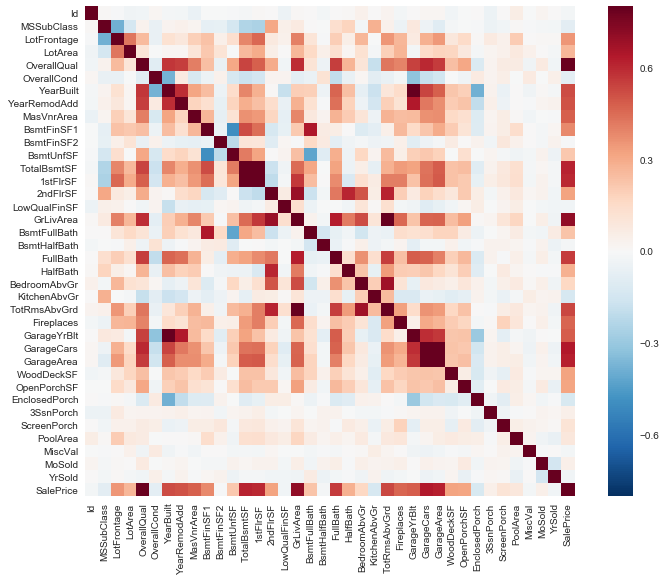

In [16]:
corrmat2 = train_raw.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat2, vmax=.8, square=True);

corrmat = train_all.corr()
print corrmat.loc[:,corrmat.columns=='SalePrice'].sort_values('SalePrice', ascending=False)

In [17]:
#Maybe Use Decision Tree/Random Forests to Pick Best Features?

rf = RandomForestRegressor(max_depth=3, n_estimators=1000)

rf.fit(train_clean,train_price)

best_features = np.where(rf.feature_importances_!=0)[0]
for i in best_features[:15]:
    print list(train_clean)[i]

print len(best_features)

Fireplaces
FullBath
GarageCars
GrLivArea
LotArea
LotFrontage
OverallQual
YearBuilt
YearRemodAdd
TotalSF
GrLivAreaSq
BsmtQual_Ex
BsmtQual_Gd
BsmtQual_TA
CentralAir_N
45


In [18]:
#pick the features that the random forest thought were the most important
train_X_sel = train_X.loc[:, train_X.columns[[best_features]]]
dev_X_sel = dev_X.loc[:, dev_X.columns[[best_features]]]

#fit the regression model using those columns only
rf_LR = linear_model.LinearRegression()
rf_LR.fit(X = train_X_sel, y = train_y)


print("y-intercept: {:,.2f}".format(float(rf_LR.intercept_)))
#print("Other Coefficients:", (rf_LR.coef_))

#make predictions
rf_LR_pred_labels = rf_LR.predict(dev_X_sel)

#print a few actual and predicted values
print dev_y[:10]
print rf_LR_pred_labels[:10]

#check the error
print("Log Root Mean Squared Error: {:,.4f}".format(metrics.mean_squared_error((dev_y), (rf_LR_pred_labels)) ** 0.5))

# Calculate R-squared values of model.
print("R-squared: {:.2f}".format(metrics.r2_score(dev_y, rf_LR_pred_labels)))

test_model(rf_LR, train_X_sel, dev_X_sel, train_y, dev_y)


y-intercept: 7.97
701     11.849398
141     12.468437
204     11.608236
799     12.072541
194     11.751942
873     11.798104
722     11.732061
952     11.804849
1077    11.840789
645     11.872347
Name: SalePrice, dtype: float64
[ 11.96963098  12.32520944  11.57320402  11.97856266  11.63671288
  11.80550334  11.6497622   11.68439282  11.81971195  11.84438973]
Log Root Mean Squared Error: 0.1345
R-squared: 0.88
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False) 

Model results based on training data
R2: 0.880917802436
RMSE: 0.138549098133 

Model results based on dev data
R2: 0.883368710066
RMSE: 0.134515709342 



In [19]:
# Data for Boosting and Lasso

train_X_xgb = train_X.copy()
train_y_xgb = train_y.copy()
dev_X_xgb = dev_X.copy()
dev_y_xgb = dev_y.copy()
test_xgb = test_all.copy()
all_xgb = train_all.copy()


all_xgb_X, all_xgb_y = all_xgb.loc[:, all_xgb.columns !='SalePrice'], all_xgb.loc[:, all_xgb.columns == 'SalePrice']
all_xgb_y = np.log(all_xgb_y)
all_xgb_X = all_xgb_X.loc[:, all_xgb_X.columns !='Id']# Drop variables that had |correlation| < 0.2 to sale price


def try_to_drop(df, col):
    try:
        df.drop(col, axis=1, inplace=True)
    except Exception:
        pass
    return df

for col in corrmat.SalePrice.loc[np.abs(corrmat.SalePrice) < 0.2].index:
    train_X_xgb = try_to_drop(train_X_xgb, col)
    dev_X_xgb = try_to_drop(dev_X_xgb, col)
    test_xgb = try_to_drop(test_xgb, col)
    all_xgb_X = try_to_drop(all_xgb_X, col)


In [20]:
print train_X.shape
print train_X_xgb.shape

(1022, 263)
(1022, 94)


In [21]:
# Boosting

def tuner(xgb, param_grid):
    grid_search = GridSearchCV(xgb, param_grid, n_jobs=-1)
    grid_search.fit(train_X_xgb, train_y_xgb)
    print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
    header = ['mean_scr', 'std_scr', 'n_est', 'lrn_rate', 'max_depth', 'gamma', 'subsample', 'reg_alpha']
    rows = []
    for x in grid_search.cv_results_['rank_test_score']:
        rows.append(['{:.6f}'.format(grid_search.cv_results_['mean_test_score'][x-1]),
                     '{:.3f}'.format(grid_search.cv_results_['std_test_score'][x-1]),
                     grid_search.cv_results_['param_n_estimators'][x-1], 
                     grid_search.cv_results_['param_learning_rate'][x-1],
                     grid_search.cv_results_['param_max_depth'][x-1],
                     grid_search.cv_results_['param_gamma'][x-1],
                     grid_search.cv_results_['param_subsample'][x-1],
                     grid_search.cv_results_['param_reg_alpha'][x-1]])
    print tabulate(rows, headers=header, tablefmt='orgtbl')
    return grid_search

def make_param_grid(n_estimators=[100], learning_rate=[0.1], max_depth=[5], gamma=[0], subsample=[0.8], reg_alpha=[0]):
    param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                 gamma=gamma, subsample=subsample, reg_alpha=reg_alpha)
    return param_grid

In [22]:
conduct_tuning = False

In [23]:
if conduct_tuning:
    xgb = XGBRegressor()
    n_estimators = [75, 80, 85, 90, 100, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170]
    print('Tuning n_estimators first')
    n_est_result = tuner(xgb, make_param_grid(n_estimators=n_estimators))

In [24]:
if conduct_tuning:
    max_depth = [3, 4, 5, 6, 7, 8, 9, 10]
    print('Tuning max_depth')
    max_depth_result = tuner(xgb, make_param_grid(max_depth=max_depth,
                                                  n_estimators=[n_est_result.best_params_['n_estimators']]))

In [25]:
if conduct_tuning:
    gamma = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    print('Tuning gamma')
    gamma_result = tuner(xgb, make_param_grid(gamma=gamma,
                                              n_estimators=[n_est_result.best_params_['n_estimators']],
                                              max_depth=[max_depth_result.best_params_['max_depth']]))

In [26]:
if conduct_tuning:
    subsample = [0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9]
    print('Tuning subsample')
    subsample_result = tuner(xgb, make_param_grid(subsample=subsample,
                                                  n_estimators=[n_est_result.best_params_['n_estimators']],
                                                  max_depth=[max_depth_result.best_params_['max_depth']],
                                                  gamma=[gamma_result.best_params_['gamma']]))

In [27]:
if conduct_tuning:
    reg_alpha = [0, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
    print('Tuning reg_alpha')
    reg_alpha_result = tuner(xgb, make_param_grid(reg_alpha=reg_alpha,
                                                  n_estimators=[n_est_result.best_params_['n_estimators']],
                                                  max_depth=[max_depth_result.best_params_['max_depth']],
                                                  gamma=[gamma_result.best_params_['gamma']],
                                                  subsample=[subsample_result.best_params_['subsample']]))

In [28]:
if conduct_tuning:
    learning_rate = [0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14]
    print('Tuning learning_rate')
    learning_rate_result = tuner(xgb, make_param_grid(learning_rate=learning_rate,
                                                      reg_alpha=[reg_alpha_result.best_params_['reg_alpha']],
                                                      n_estimators=[n_est_result.best_params_['n_estimators']],
                                                      max_depth=[max_depth_result.best_params_['max_depth']],
                                                      gamma=[gamma_result.best_params_['gamma']],
                                                      subsample=[subsample_result.best_params_['subsample']]))

In [29]:
if conduct_tuning:
    print('Re-tuning n_estimators and max_depth for fun')
    n_estimators = [90, 100, 130, 140, 150, 160, 170, 180, 200]
    max_depth = [2, 3, 4, 5]
    gamma = [0]
    subsample = [0.80]
    reg_alpha = [.0001]
    all_result = tuner(xgb, make_param_grid(learning_rate=learning_rate, reg_alpha=reg_alpha, n_estimators=n_estimators,
                                            max_depth=max_depth, gamma=gamma, subsample=subsample))

In [30]:
xgb_final_train_model = XGBRegressor(learning_rate=0.1, reg_alpha=0.0001, n_estimators=100, max_depth=4, gamma=0, subsample=0.8)
xgb_final_train_model.fit(train_X_xgb, train_y_xgb)
print("Log Root Mean Squared Error: {:,.4f}"
      .format(mean_squared_error(dev_y_xgb, xgb_final_train_model.predict(dev_X_xgb)) ** 0.5))

test_model(xgb_final_train_model, train_X_xgb, dev_X_xgb, train_y_xgb, dev_y_xgb)


Log Root Mean Squared Error: 0.1311
XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0.0001, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8) 

Model results based on training data
R2: 0.958291582153
RMSE: 0.0819959006831 

Model results based on dev data
R2: 0.889242290627
RMSE: 0.131084834277 



In [31]:
xgb_final_train_model2 = XGBRegressor(learning_rate=0.1, reg_alpha=0.0001, n_estimators=180, max_depth=3, gamma=0, subsample=0.8)
xgb_final_train_model2.fit(train_X_xgb, train_y_xgb)
test_model(xgb_final_train_model2, train_X_xgb, dev_X_xgb, train_y_xgb, dev_y_xgb)


XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=180, nthread=-1,
       objective='reg:linear', reg_alpha=0.0001, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8) 

Model results based on training data
R2: 0.957745116106
RMSE: 0.082531310111 

Model results based on dev data
R2: 0.893232636222
RMSE: 0.128701831281 



In [32]:
# See if we can make the model more general by improving RMSLE on the dev data with more tuning

conduct_more_tuning = True
to_beat = mean_squared_error(dev_y_xgb, xgb_final_train_model.predict(dev_X_xgb)) ** 0.5

In [33]:
if conduct_more_tuning:
    best_n_estimators = xgb_final_train_model.get_params()['n_estimators']
    best_max_depth = xgb_final_train_model.get_params()['max_depth']
    print('RMSLE to beat is {:.4f}'.format(to_beat))
    print('Tuning n_estimators and max_depth')
    new_best_found = False
    for n_estimators in [90, 100, 140, 200, 300, 400]:
        for max_depth in [3, 4, 5, 6]:
            xgb_dev_model = XGBRegressor(learning_rate=0.1, reg_alpha=1e-5, n_estimators=n_estimators,
                                         max_depth=max_depth, gamma=0, subsample=0.8)
            xgb_dev_model.fit(train_X_xgb, train_y_xgb)
            new_rmsle = mean_squared_error(dev_y_xgb, xgb_dev_model.predict(dev_X_xgb)) ** 0.5
            if new_rmsle < to_beat:
                new_best_found = True
                print('New best: RMSLE = {:.4f} with n_estimators = {} and max_depth = {}'
                      .format(new_rmsle, xgb_dev_model.get_params()['n_estimators'], xgb_dev_model.get_params()['max_depth']))
                to_beat = new_rmsle
                best_n_estimators = xgb_dev_model.get_params()['n_estimators']
                best_max_depth = xgb_dev_model.get_params()['max_depth']
    if not new_best_found:
        print('No new best found')

RMSLE to beat is 0.1311
Tuning n_estimators and max_depth
New best: RMSLE = 0.1306 with n_estimators = 90 and max_depth = 3
New best: RMSLE = 0.1300 with n_estimators = 100 and max_depth = 3
New best: RMSLE = 0.1292 with n_estimators = 140 and max_depth = 3
New best: RMSLE = 0.1290 with n_estimators = 200 and max_depth = 3
New best: RMSLE = 0.1280 with n_estimators = 300 and max_depth = 3


In [34]:
if conduct_more_tuning:
    best_gamma = xgb_final_train_model.get_params()['gamma']
    best_subsample = xgb_final_train_model.get_params()['subsample']
    print('RMSLE to beat is {:.4f}'.format(to_beat))
    print('Tuning gamma and subsample')
    new_best_found = False
    for gamma in [0, 0.1, 0.2]:
        for subsample in [0.7, 0.8, 0.9]:
            xgb_dev_model = XGBRegressor(learning_rate=0.1, reg_alpha=1e-5, n_estimators=140,
                                         max_depth=5, gamma=gamma, subsample=subsample)
            xgb_dev_model.fit(train_X_xgb, train_y_xgb)
            new_rmsle = mean_squared_error(dev_y_xgb, xgb_dev_model.predict(dev_X_xgb)) ** 0.5
            if new_rmsle < to_beat:
                new_best_found = True
                print('New best: RMSLE = {:.4f} with gamma = {} and subsample = {}'
                      .format(new_rmsle, xgb_dev_model.get_params()['gamma'], xgb_dev_model.get_params()['subsample']))
                to_beat = new_rmsle
                best_gamma = xgb_dev_model.get_params()['gamma']
                best_subsample = xgb_dev_model.get_params()['subsample']
    if not new_best_found:
        print('No new best found')

RMSLE to beat is 0.1280
Tuning gamma and subsample
New best: RMSLE = 0.1279 with gamma = 0 and subsample = 0.9


In [35]:
if conduct_more_tuning:
    best_reg_alpha = xgb_final_train_model.get_params()['reg_alpha']
    best_learning_rate = xgb_final_train_model.get_params()['learning_rate']
    print('RMSLE to beat is {:.4f}'.format(to_beat))
    print('Tuning reg_alpha and learning_rate')
    new_best_found = False
    for reg_alpha in [0, 0.1, 0.2]:
        for learning_rate in [0.7, 0.8, 0.9]:
            xgb_dev_model = XGBRegressor(learning_rate=learning_rate, reg_alpha=reg_alpha, n_estimators=140,
                                         max_depth=5, gamma=0, subsample=0.8)
            xgb_dev_model.fit(train_X_xgb, train_y_xgb)
            new_rmsle = mean_squared_error(dev_y_xgb, xgb_dev_model.predict(dev_X_xgb)) ** 0.5
            if new_rmsle < to_beat:
                new_best_found = True
                print('New best: RMSLE = {:.4f} with reg_alpha = {} and learning_rate = {}'
                      .format(new_rmsle, xgb_dev_model.get_params()['reg_alpha'], xgb_dev_model.get_params()['learning_rate']))
                to_beat = new_rmsle
                best_reg_alpha = xgb_dev_model.get_params()['reg_alpha']
                best_learning_rate = xgb_dev_model.get_params()['learning_rate']
    if not new_best_found:
        print('No new best found')

RMSLE to beat is 0.1279
Tuning reg_alpha and learning_rate
No new best found


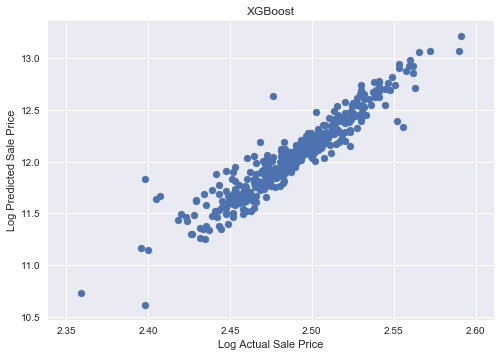

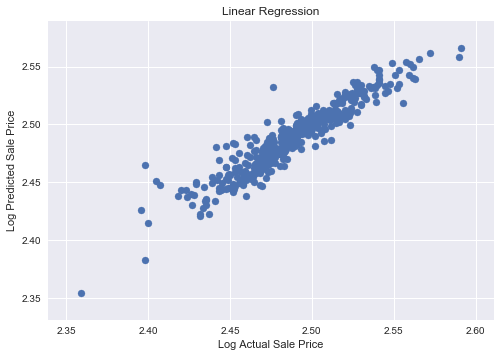

Root Mean Squared Log Error XGBoost: 0.1290
Root Mean Squared Log Error Linear Regression: 0.1345


In [36]:
xgb_optim = XGBRegressor(learning_rate=0.1, reg_alpha=0.0001, n_estimators=200, max_depth=3, gamma=0, subsample=0.8)
xgb_optim.fit(train_X_xgb, train_y_xgb)
plt.scatter(np.log(dev_y), xgb_optim.predict(dev_X_xgb))
plt.title("XGBoost")
plt.xlabel("Log Actual Sale Price")
plt.ylabel("Log Predicted Sale Price")
plt.show()
plt.scatter(np.log(dev_y), np.log(rf_LR_pred_labels))
plt.title("Linear Regression")
plt.xlabel("Log Actual Sale Price")
plt.ylabel("Log Predicted Sale Price")
plt.show()
print("Root Mean Squared Log Error XGBoost: {:,.4f}"
      .format(mean_squared_error((dev_y), xgb_optim.predict(dev_X_xgb)) ** 0.5))
print("Root Mean Squared Log Error Linear Regression: {:,.4f}"
      .format(mean_squared_error((dev_y),(rf_LR_pred_labels)) ** 0.5))


In [37]:
xgb_optim_all_train = XGBRegressor(learning_rate=0.1, reg_alpha=0.0001, n_estimators=200,
                                         max_depth=3, gamma=0, subsample=0.8)
xgb_optim_all_train.fit(all_xgb_X, all_xgb_y)
xgb_predictions = pd.concat([test.Id, pd.Series(np.exp(xgb_optim_all_train.predict(test_xgb)), name='SalePrice')], axis=1)
xgb_predictions.to_csv('Output_xgb.csv', index=False)

In [38]:

def tuner_lasso(lasso, param_grid):
    grid_search = GridSearchCV(lasso, param_grid, n_jobs=-1)
    grid_search.fit(train_X_xgb, train_y_xgb)
    print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
    header = ['mean_scr', 'std_scr', 'alpha']
    rows = []
    for x in grid_search.cv_results_['rank_test_score']:
        rows.append(['{:.6f}'.format(grid_search.cv_results_['mean_test_score'][x-1]),
                     '{:.3f}'.format(grid_search.cv_results_['std_test_score'][x-1]),
                     grid_search.cv_results_['param_alpha'][x-1]])
    print tabulate(rows, headers=header, tablefmt='orgtbl')
    return grid_search

lasso = Lasso(max_iter=1e5)
lasso_param_grid = {'alpha': [5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 2e-3, 3e-3, 4e-3]}
lasso_grid_search = tuner_lasso(lasso, lasso_param_grid)

Best: 0.859132 using {'alpha': 0.0008}
|   mean_scr |   std_scr |   alpha |
|------------+-----------+---------|
|   0.859132 |     0.019 |  0.0009 |
|   0.859132 |     0.019 |  0.0008 |
|   0.859002 |     0.019 |  0.0007 |
|   0.858366 |     0.019 |  0.0005 |
|   0.858745 |     0.019 |  0.0006 |
|   0.856859 |     0.021 |  0.002  |
|   0.855415 |     0.021 |  0.003  |
|   0.852856 |     0.021 |  0.004  |


In [39]:
# Use same features as xgboost with a lasso regression

lasso_optim = Lasso(max_iter=1e5, alpha=0.0007)
lasso_optim.fit(train_X_xgb, train_y_xgb)
print("Root Mean Squared Log Error Lasso Regression: {:,.4f}"
      .format(mean_squared_error((dev_y), lasso_optim.predict(dev_X_xgb)) ** 0.5))

lasso_optim_all_train = lasso_optim.fit(all_xgb_X, all_xgb_y)
lasso_predictions = pd.concat([test.Id, pd.Series(np.exp(lasso_optim_all_train.predict(test_xgb)), name='SalePrice')], axis=1)
lasso_predictions.to_csv('Output_lasso.csv', index=False)

Root Mean Squared Log Error Lasso Regression: 0.1265


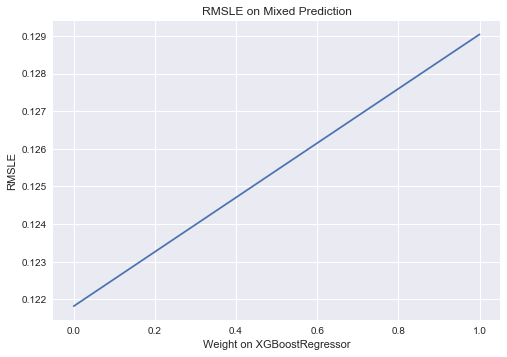

In [40]:
# Combine the two predictions to determine the best mixing weight

xgb_weight = [x/20 for x in range(21)]
mixed_rmsle = []
pred_xgb = xgb_optim.predict(dev_X_xgb)
pred_lasso = lasso_optim.predict(dev_X_xgb)
for x in xgb_weight:
    wtd_pred = x * pred_xgb + (1 - x) * pred_lasso
    rmsle = mean_squared_error((dev_y), wtd_pred) ** 0.5
    mixed_rmsle.append(rmsle)

plt.plot(xgb_weight, mixed_rmsle)
plt.title('RMSLE on Mixed Prediction')
plt.xlabel('Weight on XGBoostRegressor')
plt.ylabel('RMSLE')
plt.show()

**This cell is from an earlier version of the model but it is worth preserving.**  
The RMSLE is linear in weight so there's not much to be gained from this information. The lasso regression appears to do worse for predicting the dev data, but submitting the fully trained xgboost regression and lasso regression results to kaggle yields 0.14169 and 0.13902 respectively -- in this case, the lasso estimator is actually better for the test data.

So, naively, we'll try two 50/50 splits: average the model output (a log price) and average the respective price.

**Update**  
The most recent results as of this writing are kaggle scores of 0.13833 and 0.14095 for the xgboost and lasso regressions, respectively. They are still very close to each other, but xgboost had a slight edge this time. On this particular run, xgboost regression looked worse on our dev data, but performed better on the kaggle test data. This is the opposite pattern from before.

In [41]:
avg_log_price_predictions = 0.5 * xgb_optim_all_train.predict(test_xgb) + 0.5 * lasso_optim_all_train.predict(test_xgb)
avg_price_predictions = (0.5 * np.exp(xgb_optim_all_train.predict(test_xgb)) + 
                         0.5 * np.exp(lasso_optim_all_train.predict(test_xgb)))
alp_out = pd.concat([test.Id, pd.Series(np.exp(avg_log_price_predictions), name='SalePrice')], axis=1)
ap_out = pd.concat([test.Id, pd.Series(avg_price_predictions, name='SalePrice')], axis=1)
alp_out.to_csv('Output_avg_log_price.csv', index=False)
ap_out.to_csv('Output_avg_price.csv', index=False)

Cumulative fraction of total variance explained by first k principal components

k =   1: 0.825
k =   2: 0.988
k =   3: 0.993
k =   4: 0.994
k =   5: 0.995


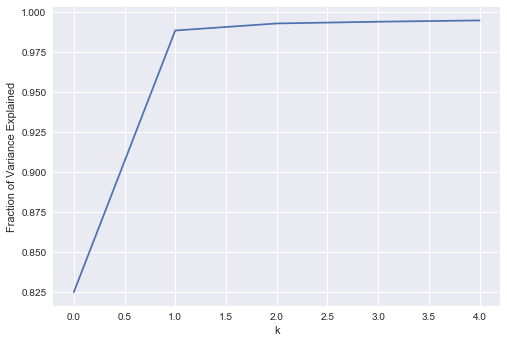

In [42]:
pca = PCA(n_components=5)
pca.fit(train_X_xgb)
explained_array = np.cumsum(pca.explained_variance_ratio_)
print("Cumulative fraction of total variance explained by first k principal components\n")
for x in range(explained_array.shape[0]):
    print("k = {:3d}: {:.3f}".format(x+1, explained_array[x]))
plt.plot(explained_array); plt.xlabel('k'); plt.ylabel('Fraction of Variance Explained')
plt.show()

In [43]:
pca_13 = PCA(n_components=13)
pca_13.fit(train_X_xgb)
pca_lr = linear_model.LinearRegression()
pca_lr.fit(pca_13.transform(train_X_xgb), train_y_xgb)

print("Root Mean Squared Log Error PCA/Linear Regression: {:,.4f}"
      .format(mean_squared_error((dev_y), pca_lr.predict(pca_13.transform(dev_X_xgb))) ** 0.5))
test_model(pca_lr, pca_13.transform(train_X_xgb), pca_13.transform(dev_X_xgb), train_y_xgb, dev_y)

Root Mean Squared Log Error PCA/Linear Regression: 0.1364
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False) 

Model results based on training data
R2: 0.854502983287
RMSE: 0.15314658859 

Model results based on dev data
R2: 0.88000354674
RMSE: 0.136442501036 



Weights for [PCA, RF, XGB, Lasso]
Best Weights: [0.0, 0.0, 0.25, 0.75]
Root Mean Squared Log Error Ensemble: 0.120770


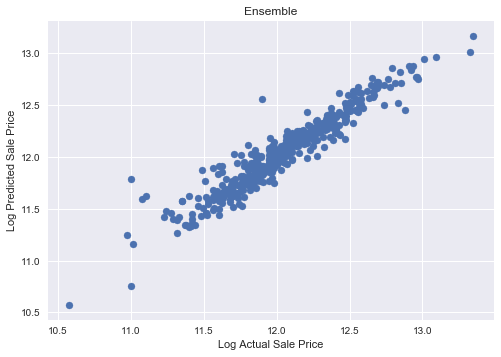

In [44]:
def ensemble1(predictions, weights):
    if len(predictions)!=len(weights):
        print "Number of estimators does not match number of weights"
    elif np.sum(weights)!=1:
        print "Weights must add up to 1"
    else:
        final_pred=np.average(predictions, axis=0, weights=weights)
        return final_pred

pca_pred = pca_lr.predict(pca_13.transform(dev_X_xgb))
rf_LR_pred = rf_LR.predict(dev_X_sel)
xgb_optim_pred = xgb_optim.predict(dev_X_xgb)
lasso_pred = lasso_optim.predict(dev_X_xgb)

predictions=[pca_pred, rf_LR_pred, xgb_optim_pred, lasso_pred]
a, b, c, d = [x/20. for x in range(21)],[x/20. for x in range(21)],[x/20. for x in range(21)],[x/20. for x in range(21)]
best_wts = [0,0,0,1]
best_rmse = mean_squared_error((dev_y), ensemble1(predictions, best_wts)) ** 0.5
for i in a:
    for j in b:
        for k in c: 
            for l in d:
                if i+j+k+l==1:
                    wts = [i,j,k,l]
                    rmse = mean_squared_error((dev_y), ensemble1(predictions, wts)) ** 0.5
                    if rmse < best_rmse:
                        best_rmse=rmse
                        best_wts = wts
                        #print wts, "Root Mean Squared Log Error Ensemble: {:,.6f}".format(rmse)
print "Weights for [PCA, RF, XGB, Lasso]"                        
print "Best Weights:", best_wts
print "Root Mean Squared Log Error Ensemble: {:,.6f}".format(best_rmse)


plt.scatter((dev_y), ensemble1(predictions, best_wts))
plt.title("Ensemble")
plt.xlabel("Log Actual Sale Price")
plt.ylabel("Log Predicted Sale Price")
plt.show()

Experimenting with a couple more models:

In [45]:
# Elastic Net model with iterative fitting along a regularization path
# The best model is selected by cross-validation.

regr = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
                                    l1_ratio=[.01, .1, .5, .9, .99], 
                                    max_iter=5000)
regr.fit(train_X, train_y)
test_model(regr, train_X, dev_X, train_y, dev_y)

/Users/mona/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], copy_X=True,
       cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.1, 0.5, 0.9, 0.99], max_iter=5000, n_alphas=100,
       n_jobs=1, normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0) 

Model results based on training data
R2: 0.910976324877
RMSE: 0.119793441671 

Model results based on dev data
R2: 0.912731042237
RMSE: 0.116357762482 



In [46]:
gb = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber')
gb.fit(train_X, train_y)
test_model(gb, train_X, dev_X, train_y, dev_y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=15,
             min_samples_split=10, min_weight_fraction_leaf=0.0,
             n_estimators=3000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False) 

Model results based on training data
R2: 0.966090384548
RMSE: 0.0739335764539 

Model results based on dev data
R2: 0.911775063402
RMSE: 0.116993341207 



### Summary
For all our model, we want to test for accuracy using 5-fold cross validation.


In [49]:
print 'Model Summary:  Accuracy with 5-fold Cross Validation'
print '-----------------------------------------------------'
print 'Original baseline: \t\t', cross_validate(simple_LR, train_clean.GrLivArea.values.reshape(-1, 1), train_price, 5)
print 'Regression w/ Random Forest: \t', cross_validate(rf_LR, train_clean.loc[:, train_X.columns[[best_features]]], train_price, 5)
print 'Optimized XGBoost: \t\t', cross_validate(xgb_optim, all_xgb_X, all_xgb_y, 5)
print 'Lasso: \t\t\t\t', cross_validate(lasso_optim, all_xgb_X, all_xgb_y, 5)
print 'Elastic Net: \t\t\t', cross_validate(regr, train_clean, train_price, 5)
print 'Gradient Boost Regressor: \t', cross_validate(gb, train_clean, train_price, 5)
print 'PCA Linear Regression: \t\t', cross_validate(pca_lr, pca_13.transform(all_xgb_X), all_xgb_y, 5)


Model Summary:  Accuracy with 5-fold Cross Validation
-----------------------------------------------------
Original baseline: 		0.527371703054
Regression w/ Random Forest: 	0.870158926994
Optimized XGBoost: 		0.880192786987
Lasso: 				0.872811943982
Elastic Net: 			0.894350457509
Gradient Boost Regressor: 	0.895092422536
PCA Linear Regression: 		0.858266879266


In [50]:
#Retrain ensemble on all training data, if not done already

#PCA on all training data
pca_13_all = PCA(n_components=13)
pca_13_all.fit(all_xgb_X)
pca_lr_all = linear_model.LinearRegression()
pca_lr_all.fit(pca_13.transform(all_xgb_X), all_xgb_y)


#Random Forest on all training data
rf_all = RandomForestRegressor(max_depth=6, n_estimators=100)
rf_all.fit(all_xgb_X,all_xgb_y)
features_all = np.where(rf_all.feature_importances_!=0)[0]

#pick the features that the random forest thought were the most important
all_X_sel = all_xgb_X.loc[:, all_xgb_X.columns[[features_all]]]
test_X_sel = test_xgb.loc[:,test_xgb.columns[[features_all]]]

#fit the regression model using those columns only
rf_LR_all = linear_model.LinearRegression()
rf_LR_all.fit(X = all_X_sel, y = all_xgb_y)


pca_pred_t = pca_lr_all.predict(pca_13.transform(test_xgb)).ravel()
rf_LR_pred_t = rf_LR_all.predict(test_X_sel).ravel()
xgb_optim_pred_t = xgb_optim_all_train.predict(test_xgb).ravel()
lasso_pred_t = lasso_optim_all_train.predict(test_xgb).ravel()

predictions_test=[np.exp(pca_pred_t), np.exp(rf_LR_pred_t), np.exp(xgb_optim_pred_t), np.exp(lasso_pred_t).ravel()]

avg_price_predictions = ensemble1(predictions_test, best_wts)
ap_out = pd.concat([test.Id, pd.Series(avg_price_predictions, name='SalePrice')], axis=1)
ap_out.to_csv('Output_avg_price_ensemble.csv', index=False)

/Users/mona/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
